# Desease Spread Simulation (Animation)

This notebook is motivated by the tweet: https://twitter.com/TedPetrou/status/1253792528593190912?s=20. This served as a perfect excuse to explore [animations with matplotlib](https://matplotlib.org/3.1.1/api/animation_api.html). 

**Warning:** This notebook does not aim to explain/predict anything related with [covid19](https://en.wikipedia.org/wiki/Coronavirus_disease_2019) (I leave this to the experts!). Plase take this as a programing/data-viz exercise. 

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['dark_background'])
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

## Model Definiton

We define a class `Body` to represent each individual. 
- Each body has a postion (x, y coordinates) inside a box of size $L>0$ (when it hits a boundary it rebounds). 
- A body can move randomly (normal steps) within the box. We record each position after a movement. 
- A body has a health status: *sick* or *not sick*.
- We assume that, if the body is sick, then it can infect other bodies with a probability (via Bernoulli distribution) $\exp(-d/\tau)$, where $d$ is the distance between two bodies and $\tau$ is a characteristic infection distance parameter.
- We record the health history on demand (not after every interaction). 

In [2]:
L = 100

class Body():

    def __init__(self, x0, y0, box_size=L, sigma=0.02, inf_dist=2):
        self.box_size = box_size
        self.x = x0
        self.y = y0
        self.sigma = sigma
        self.loc_history = [(x0, y0)]
        self.is_sick = False
        self.health_history = [False]
        self.inf_dist = inf_dist

    def add_to_loc_history(self, x, y):
        self.loc_history.append((x, y))

    def add_to_health_history(self, x):
        self.health_history.append(x)

    def get_infected(self):
        self.is_sick = True

    @staticmethod
    def new_position(z, dz, box_size):
        zhat = abs(z + dz)

        if(zhat > box_size):
            zhat = 2*box_size - zhat
        return zhat

    def move(self):
        sigma = self.sigma * self.box_size
        dx = np.random.normal(loc=0.0, scale=sigma)
        dy = np.random.normal(loc=0.0, scale=sigma)

        self.x = Body.new_position(z=self.x, dz=dx, box_size=self.box_size)
        self.y = Body.new_position(z=self.y, dz=dy, box_size=self.box_size)
        self.add_to_loc_history(self.x, self.y)

    def distance(self, other): 
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def interact(self, other):
        dist = self.distance(other)
        status = self.is_sick + other.is_sick

        if ((status % 2) != 0):

            if (self.is_sick):
                prob = np.exp(-dist/self.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)
                if (change_status):
                    other.get_infected()
            else:
                prob = np.exp(-dist/other.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)
                if (change_status):
                    self.get_infected()

Let us see an example:

In [11]:
b1 = Body(0, 0)
b2 = Body(0.1, 0)
print('B1 is sick: ' + str(b1.is_sick))
print('B2 is sick: ' + str(b2.is_sick))

B1 is sick: False
B2 is sick: False


In [12]:
b2.get_infected()
b1.interact(b2)
print('B1 is sick: ' + str(b1.is_sick))
print('B2 is sick: ' + str(b2.is_sick))

B1 is sick: True
B2 is sick: True


Next let us deidine the `Simulation` class. This just makes a set of bodies ineract in a box. The simulation starts wth just one sick body. 

In [13]:
class Simulation():

    def __init__(self, n_bodies, num, box_size=L, inf_dist=2):
        self.box_size = box_size
        self.n_bodies = n_bodies
        self.num = num
        self.bodies = [
            Body(
                x0=np.random.uniform(low=0.0, high=self.box_size),
                y0=np.random.uniform(low=0.0, high=self.box_size),
                box_size=self.box_size,
                inf_dist=inf_dist
            )
            for i in range(0, self.n_bodies)
        ]
        self.hist_len = 1

    def run(self):
        self.bodies[0].get_infected()
        for i in range(self.num):
            for j, b1 in enumerate(self.bodies):
                for k, b2 in enumerate(self.bodies):
                    if (j < k):
                        b1.interact(b2)
            [b.add_to_health_history(b.is_sick) for b in self.bodies]
            [b.move() for b in self.bodies]
        self.hist_len = self.hist_len + self.num

    def animate(self):
        fig, ax = plt.subplots()
        ax.set(title='Animation', xlim=(0, self.box_size), ylim=(0, self.box_size))
        scat = ax.scatter(x=[], y=[], c='black', linewidths=4)

        def update(i):
            x = [b.loc_history[i][0] for b in self.bodies]
            y = [b.loc_history[i][1] for b in self.bodies]
            x = np.array(x).reshape(-1, 1)
            y = np.array(y).reshape(-1, 1)
            scat.set_offsets(np.concatenate((x, y), axis=1))
            scat.set_edgecolors(np.array([sns_c[3] if b.health_history[i] else sns_c[2] for b in self.bodies]))
            return scat,  

        anim = FuncAnimation(fig, update, frames=self.hist_len, interval=200, blit=True)
        return anim

## Results

First, let us plot a movement of one single body:

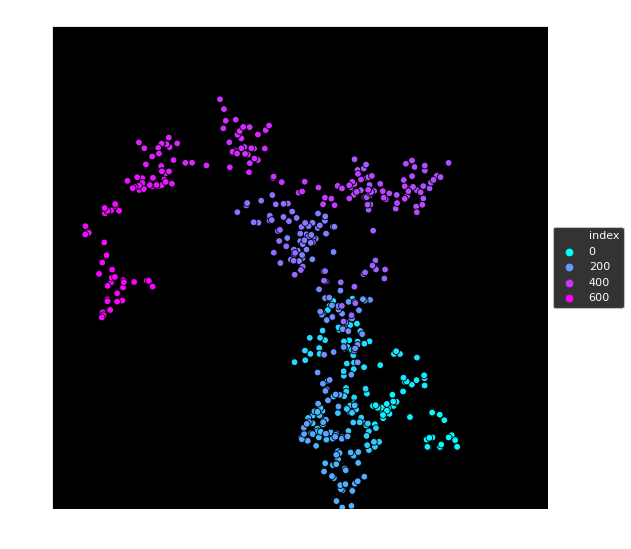

In [50]:
sim_1 = Simulation(n_bodies=1, num=500)
sim_1.run()

body_history_df = pd.DataFrame(sim_1.bodies[0].loc_history, columns=['x', 'y']).reset_index()

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', hue='index', palette='cool', edgecolor='black', data=body_history_df, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title=f'One Body Movement - {sim_1.num} Steps', xlim=(0.0, L), ylim=(0.0, L))
plt.savefig('one_body.png', dpi=200, bbox_inches='tight');

Next, let us generate an animation for `n_bodies = 200` and `num=100` (iterations).

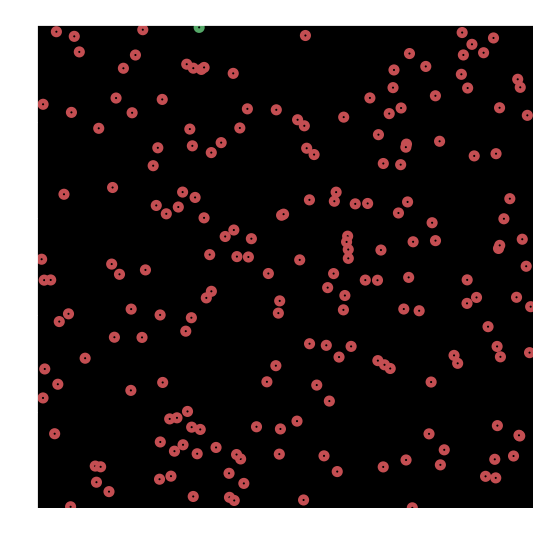

In [51]:
sim = Simulation(n_bodies=200, num=100)
sim.run()

anim = sim.animate() 
HTML(anim.to_jshtml())
anim.save('animation.gif', writer='imagemagick', fps=10)

Finally, let us decrease the characteristic infection distance parameter to `inf_dist=0.5`. We indeed see the infection speed decreases. 

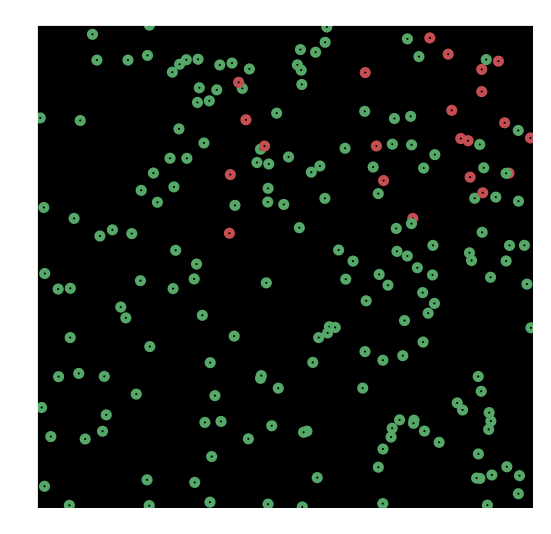

In [8]:
sim2 = Simulation(n_bodies=200, num=100, inf_dist=0.5)
sim2.run()

anim2 = sim2.animate() 
HTML(anim2.to_jshtml())
anim2.save('animation2.gif', writer='imagemagick', fps=10)

--- 
## Remark: Animation with Matplotlib

This use case was a perfect setting to explore the animation module of Matplotlib. 

- I belve is very powerfull, but non-trivial to start with. I found [this](https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot) stackoverflow thread very useful. 

- I was not able to do a simple task: color the points based on the health status via `scat.set_array(...)`. I had to color the edges of the points (if you manage do do it please let me know). 

-  It would be great to generate animations using [seaborn](https://seaborn.pydata.org/).

- To save the animation as a gift you can run `# !brew install imagemagick` on a Jupyter cell. 